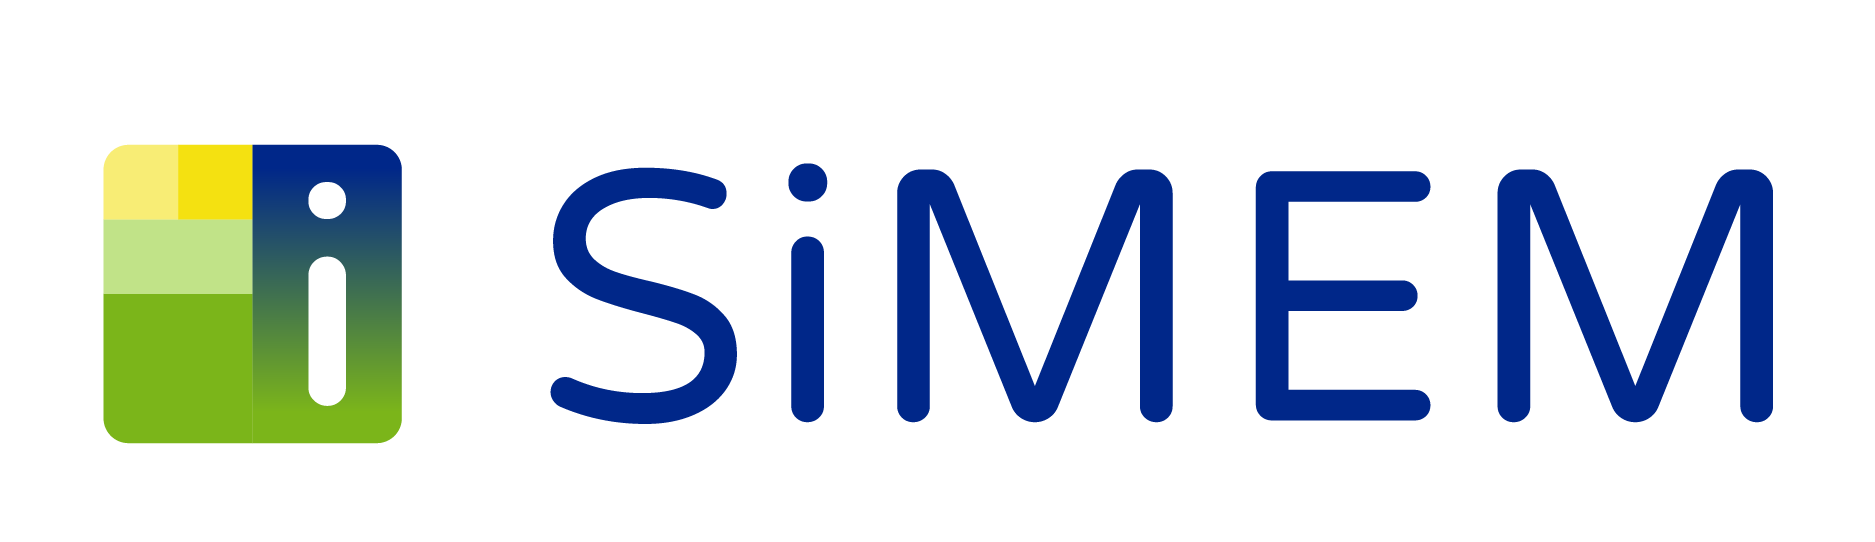

[SiMEM](https://www.simem.co/)

## Caso de uso: Estimación de ingresos de un agente en el Mercado de Energía Mayorista
 
Este notebook guía el proceso completo para estimar y comparar los ingresos mensuales de un agente del mercado eléctrico colombiano, utilizando diferentes versiones de liquidación. Se abordan desde la instalación de librerías, consulta y procesamiento de datos, hasta el análisis comparativo y visualización de resultados.
 
### Flujo de trabajo:
1. Instalación de dependencias necesarias
2. Importación de librerías para análisis y visualización
3. Definición de parámetros y consulta de datos desde SIMEM
4. Procesamiento, limpieza y transformación de datos
5. Consolidación de variables clave en un único DataFrame
6. Cálculo de ingresos y análisis comparativo entre versiones de liquidación
7. Visualización de la variación de ingresos mensuales por versión de liquidación
 
**Índice**
1. [Instalación de librerías](#section1)
2. [Importación de librerías](#section2)
3. [Consulta y procesamiento de datos](#section3)
4. [Análisis y visualización de resultados](#section4)

<a id='section1'></a>
## 1: Instalación de dependencias necesarias
Ejecuta el siguiente comando en la terminal para instalar la librería `pydataxm`, utilizada para consultar datos del sistema SIMEM.

In [60]:
# !{sys.executable} -m pip install -U pydataxm

<a id='section2'></a>
## 2: Importar librerías para análisis y visualización
Se importan las librerías necesarias para la consulta, manipulación y visualización de los datos.

In [61]:
# Importar librerías para análisis y visualización
import sys                                  # Proporciona acceso a variables y funciones del intérprete de Python
import pandas as pd                         # Librería para manipulación y análisis de datos en estructuras tipo DataFrame
import matplotlib.pyplot as plt             # Librería para visualización de datos en gráficos
import seaborn as sns                       # Librería para visualización estadística avanzada
from pydataxm.pydatasimem import ReadSIMEM  # Importa clase para interactuar con datos del sistema SIMEM
import datetime as dt                       # Módulo para trabajar con fechas y horas
from datetime import timedelta              # Importa la clase timedelta para operaciones con diferencias de tiempo

<a id='section3'></a>
## 3: Definición de parámetros y consulta de datos desde SIMEM
En esta sección se definen los parámetros de entrada y se consulta la información relevante de los conjuntos de datos del sistema SIMEM.

Se definen los parámetros de entrada y se crea el objeto `ReadSIMEM()` para realizar las consultas a los conjuntos de datos requeridos.

In [62]:
codigo_agente = ['EPMC']        # Códigos de agentes del mercado a analizar
fecha_inicial = '2025-01-01'    # Fecha de inicio del análisis
fecha_final = '2025-06-30'      # Fecha de fin del análisis
version_base = 'TXR'            # Versión base de la liquidación
version_comparacion = 'TXF'     # Versión de comparación de la liquidación

### Fórmula para la estimación del ingreso mensual del agente
La estimación del ingreso se realiza con la siguiente fórmula:
$$
\text{Ingreso} = - (\text{ComprasBolsa} \times \text{PrecioBolsa} + \text{ComprasContrato} \times \text{PrecioContrato}) + (\text{VentasBolsa} \times \text{PrecioBolsa} + \text{VentasContrato} \times \text{PrecioContrato})
$$

Los conjuntos de datos utilizados se encuentran en el [catálogo de conjuntos de datos de SIMEM](https://www.simem.co/pages/catalogodatos/51FC0A59-3A00-462C-B449-9CB8D5E007FB).
Para este análisis se consultan: [Demanda Comercial](https://www.simem.co/datadetail/D552025A-D6E6-472A-B2CE-55D28C5FBED6), [Generación ideal](https://www.simem.co/datadetail/8e7f3c69-44e6-4122-b3e8-8e04b336c33e), [Ventas en bolsa](https://www.simem.co/datadetail/e14d7065-b324-472d-9ed4-9d78a91917b8), [Compras en bolsa](https://www.simem.co/datadetail/42edc929-6f52-4f19-8a12-53ce98e53272) y [Contratos de energía](https://www.simem.co/datadetail/d316478b-b8c0-4050-49ec-08dce7ce0b90).

En algunos casos es necesario realizar agregaciones (resample) para asegurar que los datos de diferentes fuentes tengan la misma granularidad y sean comparables.

### Consulta de demanda comercial por agente
Se consulta la demanda comercial del agente seleccionado en el periodo de análisis.

In [63]:
obj_demanda_comercial = ReadSIMEM(
    dataset_id="D55202",               # ID del conjunto de datos de Demanda Comercial
    start_date=fecha_inicial,          # Fecha de inicio para la consulta
    end_date=fecha_final,              # Fecha de fin para la consulta
    filter_column="CodigoSICAgente",   # Columna para filtrar por código de agente
filter_values=codigo_agente,           # Valores para filtrar por código de agente

)
demanda_comercial = obj_demanda_comercial.main(filter=True)

****************************************************************************************************
Initializing object
The object has been initialized with the dataset: "Demanda comercial"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.0008366107940673828
Extraccion de registros: 25.935323238372803
End of data extracting process
****************************************************************************************************


### Procesamiento y filtrado de datos de demanda comercial
Se filtran las versiones de liquidación relevantes y se agrupan los datos por mes y agente.

In [64]:
# Procesamiento y filtrado de datos de demanda comercial
demanda_comercial = demanda_comercial.copy()
if demanda_comercial.empty:
    demanda_comercial = obj_demanda_comercial.main(filter=False).iloc[0:0]

demanda_comercial = demanda_comercial[demanda_comercial['Version'].isin([version_base, version_comparacion])]
demanda_comercial.rename(columns={"Valor": "DemandaComercial"}, inplace=True)
demanda_comercial["FechaHora"] = pd.to_datetime(demanda_comercial["FechaHora"])
demanda_comercial["FechaMes"] = demanda_comercial["FechaHora"].dt.to_period('M').dt.to_timestamp()
demanda_comercial = demanda_comercial.groupby(['FechaMes', 'CodigoSICAgente', 'Version'], as_index=False)['DemandaComercial'].sum()
demanda_comercial.head()

,FechaMes,CodigoSICAgente,Version,DemandaComercial
0,2025-01-01,EPMC,TXF,1.006111e+09
1,2025-01-01,EPMC,TXR,1.006112e+09
2,2025-02-01,EPMC,TXF,9.557452e+08
3,2025-02-01,EPMC,TXR,9.557452e+08
4,2025-03-01,EPMC,TXF,1.043336e+09


### Consulta de plantas asociadas al agente
Se obtiene el listado de plantas vinculadas al agente para posteriores consultas de generación.

In [65]:
obj_parametros_tecnicos = ReadSIMEM(
    dataset_id = "0bfc9d",
    start_date=fecha_inicial,
    end_date=fecha_final,
    filter_column="CodigoSICAgente",
    filter_values=codigo_agente
)

parametros_tecnicos = obj_parametros_tecnicos.main(filter=True)

if parametros_tecnicos.empty:
    plantas = None
    parametros_tecnicos = pd.DataFrame(columns=obj_parametros_tecnicos.main(filter=False).columns)
else:
    parametros_tecnicos["Fecha"] = pd.to_datetime(parametros_tecnicos["Fecha"])
    plantas = parametros_tecnicos["CodigoPlanta"].unique().tolist()
    parametros_tecnicos.head()


****************************************************************************************************
Initializing object
The object has been initialized with the dataset: "Parámetros técnicos de las plantas de generación"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.0011773109436035156
For the URL: https://www.simem.co/backend-files/api/PublicData?startdate=2025-01-01&enddate=2025-01-31&datasetId=0bfc9d&columnDestinyName=CodigoSICAgente&values=EPMC
There are 0 records
For the URL: https://www.simem.co/backend-files/api/PublicData?startdate=2025-02-01&enddate=2025-02-28&datasetId=0bfc9d&columnDestinyName=CodigoSICAgente&values=EPMC
There are 0 records
For the URL: https://www.simem.co/backend-files/api/PublicData?startdate=2025-03-01&enddate=2025-03-31&datasetId=0bfc9d&columnDestinyName=CodigoSICAgente&values=EPMC
There are 0 records
For the URL: https://www.simem.co/backend-files/api/Publ

### Consulta de generación ideal por planta
Se consulta la generación ideal para las plantas asociadas al agente en el periodo de análisis.

In [66]:
obj_generacion_ideal = ReadSIMEM(
    dataset_id = "8E7F3C",
    start_date=fecha_inicial,
    end_date=fecha_final,
    filter_column="CodigoPlanta",
    filter_values=plantas
)

generacion_ideal = obj_generacion_ideal.main(filter=True)

****************************************************************************************************
Initializing object
The object has been initialized with the dataset: "Generación ideal nacional por planta"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.0009398460388183594
Extraccion de registros: 163.7661898136139
End of data extracting process
****************************************************************************************************


### Agrupación de datos de generación ideal por día
Se realiza un resample para agrupar la generación ideal por día y facilitar el análisis mensual.

In [67]:
generacion_ideal = generacion_ideal[generacion_ideal['Version'].isin([version_base, version_comparacion])]
generacion_ideal.rename(columns={"Valor": "GeneracionIdeal"}, inplace=True)
generacion_ideal["FechaHora"] = pd.to_datetime(generacion_ideal["FechaHora"])
generacion_ideal["Fecha"] = generacion_ideal["FechaHora"].dt.to_period('D').dt.to_timestamp()

### Procesamiento y filtrado de datos de generación ideal
Se vinculan los datos de generación con el agente y se agrupan por mes y versión de liquidación.

In [68]:
# Vinculación y agrupación de generación ideal por agente y mes
gen_planta_agente = generacion_ideal.merge(parametros_tecnicos[["Fecha", "CodigoPlanta", "CodigoSICAgente"]], left_on=["Fecha","CodigoPlanta"], right_on=["Fecha","CodigoPlanta"], how="left")
gen_planta_agente = gen_planta_agente[gen_planta_agente["CodigoSICAgente"].isin(codigo_agente)]
gen_planta_agente["FechaMes"] = pd.to_datetime(gen_planta_agente["FechaHora"]).dt.to_period('M').dt.to_timestamp()
gen_planta_agente = gen_planta_agente.groupby(['FechaMes', 'CodigoSICAgente', 'Version'], as_index=False)['GeneracionIdeal'].sum()
gen_planta_agente.head()

,FechaMes,CodigoSICAgente,Version,GeneracionIdeal


### Consulta de compras en bolsa
Se consulta el volumen de compras en bolsa realizadas por el agente en el periodo de análisis.

In [69]:
obj_compras_bolsa = ReadSIMEM(
    dataset_id="42edc9",
    start_date=fecha_inicial,
    end_date=fecha_final,
    filter_column="CodigoSICAgente",
    filter_values=codigo_agente,
)

compras_bolsa = obj_compras_bolsa.main(filter=True)

****************************************************************************************************
Initializing object
The object has been initialized with the dataset: "Magnitud energía en bolsa nacional a cargo"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.0010311603546142578
Extraccion de registros: 18.552638053894043
End of data extracting process
****************************************************************************************************


### Procesamiento y filtrado de datos de compras en bolsa
Se filtran las versiones relevantes y se agrupan los datos por mes y agente.

In [70]:
# Procesamiento y filtrado de datos de compras en bolsa
compras_bolsa = compras_bolsa.copy()
compras_bolsa = compras_bolsa[compras_bolsa['Version'].isin([version_base, version_comparacion])]
compras_bolsa.rename(columns={"Valor": "ComprasBolsa"}, inplace=True)
compras_bolsa["FechaMes"] = pd.to_datetime(compras_bolsa["FechaHora"]).dt.to_period('M').dt.to_timestamp()
compras_bolsa = compras_bolsa.groupby(['FechaMes','CodigoSICAgente','Version'], as_index=False)['ComprasBolsa'].sum()
compras_bolsa.head()

,FechaMes,CodigoSICAgente,Version,ComprasBolsa
0,2025-01-01,EPMC,TXF,1.790655e+08
1,2025-01-01,EPMC,TXR,1.790647e+08
2,2025-02-01,EPMC,TXF,1.705937e+08
3,2025-02-01,EPMC,TXR,1.704778e+08
4,2025-03-01,EPMC,TXF,1.777884e+08


### Consulta de ventas en bolsa
Se consulta el volumen de ventas en bolsa realizadas por el agente en el periodo de análisis.

In [71]:
obj_ventas_bolsa = ReadSIMEM(
    dataset_id="e14d70",
    start_date=fecha_inicial,
    end_date=fecha_final,
    filter_column="CodigoSICAgente",
    filter_values=codigo_agente,
)
ventas_bolsa = obj_ventas_bolsa.main(filter=True)


****************************************************************************************************
Initializing object
The object has been initialized with the dataset: "Magnitud ventas en bolsa nacional en energía"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.0011053085327148438
Extraccion de registros: 19.915449619293213
End of data extracting process
****************************************************************************************************


### Procesamiento y filtrado de datos de ventas en bolsa
Se filtran las versiones relevantes y se agrupan los datos por mes y agente.

In [72]:
# Procesamiento y filtrado de datos de ventas en bolsa
ventas_bolsa = ventas_bolsa.copy()
ventas_bolsa = ventas_bolsa[ventas_bolsa['Version'].isin([version_base, version_comparacion])]
ventas_bolsa.rename(columns={"Valor": "VentasBolsa"}, inplace=True)
ventas_bolsa["FechaMes"] = pd.to_datetime(ventas_bolsa["FechaHora"]).dt.to_period('M').dt.to_timestamp()
ventas_bolsa = ventas_bolsa.groupby(['FechaMes','CodigoSICAgente','Version'], as_index=False)['VentasBolsa'].sum()
ventas_bolsa.head()

,FechaMes,CodigoSICAgente,Version,VentasBolsa
0,2025-01-01,EPMC,TXF,0.0
1,2025-01-01,EPMC,TXR,0.0
2,2025-02-01,EPMC,TXF,0.0
3,2025-02-01,EPMC,TXR,0.0
4,2025-03-01,EPMC,TXF,0.0


### Consulta de contratos de energía
Se consulta la información de contratos de energía asociados al agente para el periodo de análisis.

In [73]:
obj_contratos = ReadSIMEM(
    dataset_id="d31647",
    start_date=fecha_inicial,
    end_date=fecha_final,
    filter_column="CodigoAgenteComprador",
    filter_values=codigo_agente,
)

contratos = obj_contratos.main(filter=True)

****************************************************************************************************
Initializing object


The object has been initialized with the dataset: "Cantidades y precios en contratos de energía del Mercado Mayorista por comercializador"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.0010979175567626953
Extraccion de registros: 12.643973350524902
End of data extracting process
****************************************************************************************************


### Procesamiento y filtrado de datos de contratos
Se agrupan los datos de contratos por mes y agente, y se calcula el precio promedio de los contratos para cada versión de liquidación.

In [74]:
# Procesamiento y filtrado de datos de contratos
contratos = contratos.copy()
contratos = contratos[contratos['Version'].isin([version_base, version_comparacion])]
contratos["FechaMes"] = pd.to_datetime(contratos["Fecha"]).dt.to_period('M').dt.to_timestamp()
contratos = contratos.groupby(['FechaMes','CodigoAgenteComprador','Version'], as_index=False)['PPP'].mean()
contratos.rename(columns={"PPP": "PrecioContrato"}, inplace=True)
contratos.head()

,FechaMes,CodigoAgenteComprador,Version,PrecioContrato
0,2025-01-01,EPMC,TXF,299.609316
1,2025-01-01,EPMC,TXR,298.275442
2,2025-02-01,EPMC,TXF,300.176855
3,2025-02-01,EPMC,TXR,299.751411
4,2025-03-01,EPMC,TXF,292.502839


### Consulta de precio de bolsa
Se consulta el precio promedio de la energía en bolsa para el periodo y versiones de liquidación analizadas.

In [75]:
obj_precio_bolsa = ReadSIMEM(
    dataset_id="96D56E",
    start_date=fecha_inicial,
    end_date=fecha_final,
    filter_column="CodigoVariable",
    filter_values=["PPBOGReal", "PPBO"],
)
precio_bolsa = obj_precio_bolsa.main(filter=True)

****************************************************************************************************
Initializing object
The object has been initialized with the dataset: "Precio de bolsa ponderado"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.0010721683502197266
Extraccion de registros: 31.97902011871338
End of data extracting process
****************************************************************************************************


### Procesamiento de datos de precio de bolsa
Se agrupan los precios por mes y versión de liquidación para su posterior análisis.

In [76]:
# Procesamiento de datos de precio de bolsa
precio_bolsa = precio_bolsa.copy()
precio_bolsa = precio_bolsa[precio_bolsa["Version"].isin([version_base, version_comparacion])]
precio_bolsa.rename(columns={"Valor": "PrecioBolsa"}, inplace=True)
precio_bolsa["FechaMes"] = pd.to_datetime(precio_bolsa["Fecha"]).dt.to_period('M').dt.to_timestamp()
precio_bolsa = precio_bolsa.groupby(['FechaMes','Version'], as_index=False)['PrecioBolsa'].mean()
precio_bolsa.head()

,FechaMes,Version,PrecioBolsa
0,2025-01-01,TXF,524.189256
1,2025-01-01,TXR,524.263100
2,2025-02-01,TXF,433.769125
3,2025-02-01,TXR,433.920525
4,2025-03-01,TXF,231.154332


### Consolidación de variables clave en un único DataFrame
Se integran todas las variables relevantes en un solo DataFrame para facilitar el cálculo de ingresos y comparaciones entre versiones de liquidación.

In [77]:
df_final = ventas_bolsa.merge(gen_planta_agente, on=["FechaMes", "CodigoSICAgente", "Version"], how ="left").fillna(0)
df_final = df_final.merge(demanda_comercial, on=["FechaMes", "CodigoSICAgente", "Version"], how ="left").fillna(0)
df_final = df_final.merge(compras_bolsa, on=["FechaMes", "CodigoSICAgente", "Version"], how ="left").fillna(0)

df_final["ComprasContrato"] = df_final["DemandaComercial"] - df_final["ComprasBolsa"]
df_final["VentasContrato"] = df_final["GeneracionIdeal"] - df_final["VentasBolsa"]
df_final.head()

,FechaMes,CodigoSICAgente,Version,VentasBolsa,GeneracionIdeal,DemandaComercial,ComprasBolsa,ComprasContrato,VentasContrato
0,2025-01-01,EPMC,TXF,0.0,0.0,1.006111e+09,1.790655e+08,8.270460e+08,0.0
1,2025-01-01,EPMC,TXR,0.0,0.0,1.006112e+09,1.790647e+08,8.270473e+08,0.0
2,2025-02-01,EPMC,TXF,0.0,0.0,9.557452e+08,1.705937e+08,7.851515e+08,0.0
3,2025-02-01,EPMC,TXR,0.0,0.0,9.557452e+08,1.704778e+08,7.852674e+08,0.0
4,2025-03-01,EPMC,TXF,0.0,0.0,1.043336e+09,1.777884e+08,8.655476e+08,0.0


In [78]:
df_final = df_final.merge(contratos, left_on=["FechaMes", "CodigoSICAgente", "Version"], right_on=["FechaMes", "CodigoAgenteComprador", "Version"], how="left")
df_final = df_final.merge(precio_bolsa, on=["FechaMes", "Version"], how="left")

<a id='section4'></a>
## Paso 4: Análisis y visualización de resultados
En esta sección se calcula el ingreso mensual del agente y se realiza el análisis comparativo entre versiones de liquidación, visualizando los resultados para identificar tendencias y diferencias.

### Cálculo y comparación de ingresos entre versiones de liquidación
Se calcula el ingreso mensual del agente y se comparan los resultados entre las versiones de liquidación seleccionadas.

In [79]:
# Cálculo vectorizado del ingreso mensual
df_final["Ingreso"] = -(df_final["ComprasBolsa"] * df_final["PrecioBolsa"] + df_final["ComprasContrato"] * df_final["PrecioContrato"]) + (df_final["VentasBolsa"] * df_final["PrecioBolsa"] + df_final["VentasContrato"] * df_final["PrecioContrato"])

df_final.head()

,FechaMes,CodigoSICAgente,Version,VentasBolsa,GeneracionIdeal,DemandaComercial,ComprasBolsa,ComprasContrato,VentasContrato,CodigoAgenteComprador,PrecioContrato,PrecioBolsa,Ingreso
0,2025-01-01,EPMC,TXF,0.0,0.0,1.006111e+09,1.790655e+08,8.270460e+08,0.0,EPMC,299.609316,524.189256,-3.416549e+11
1,2025-01-01,EPMC,TXR,0.0,0.0,1.006112e+09,1.790647e+08,8.270473e+08,0.0,EPMC,298.275442,524.263100,-3.405649e+11
2,2025-02-01,EPMC,TXF,0.0,0.0,9.557452e+08,1.705937e+08,7.851515e+08,0.0,EPMC,300.176855,433.769125,-3.096826e+11
3,2025-02-01,EPMC,TXR,0.0,0.0,9.557452e+08,1.704778e+08,7.852674e+08,0.0,EPMC,299.751411,433.920525,-3.093588e+11
4,2025-03-01,EPMC,TXF,0.0,0.0,1.043336e+09,1.777884e+08,8.655476e+08,0.0,EPMC,292.502839,231.154332,-2.942717e+11


## Visualización de la variación de ingresos mensuales por versión de liquidación
Se grafica la evolución de los ingresos mensuales para cada versión de liquidación, facilitando la interpretación de tendencias y diferencias.

C:\Users\50601\AppData\Local\Temp\ipykernel_15732\2683527709.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_final, x='FechaMes', y=df_final['Ingreso']/1e6, hue='Version', marker='o', ci=None)


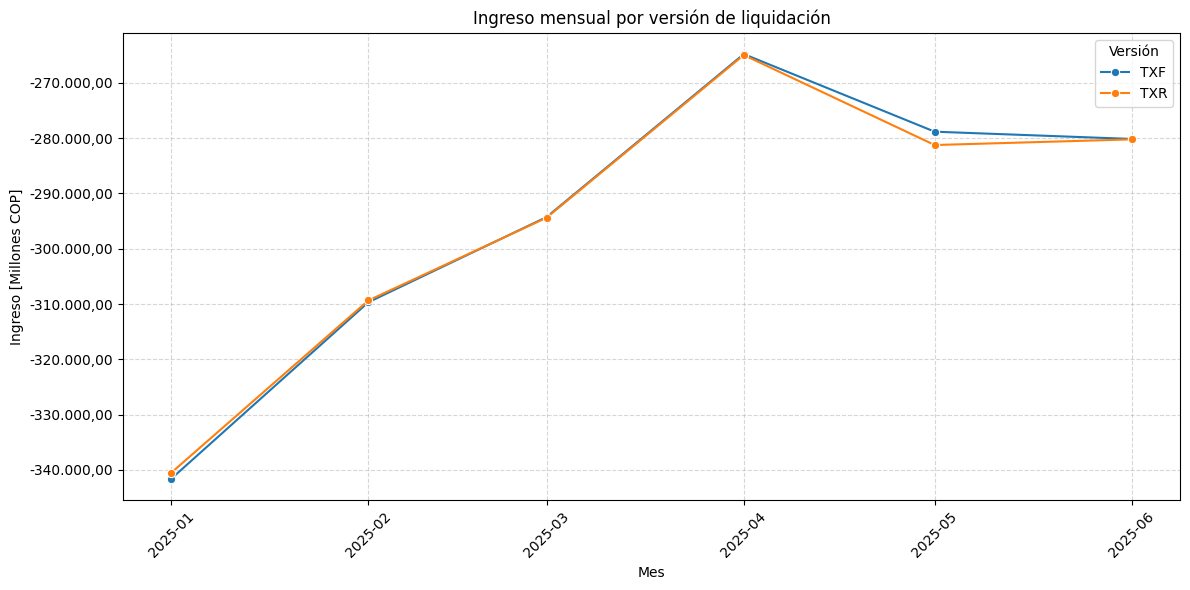

In [80]:
import matplotlib.ticker as mticker
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_final, x='FechaMes', y=df_final['Ingreso']/1e6, hue='Version', marker='o', ci=None)
plt.title('Ingreso mensual por versión de liquidación')
plt.xlabel('Mes')
plt.ylabel('Ingreso [Millones COP]')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')))
plt.legend(title='Versión')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()